In [5]:
import pandas as pd
import math
from collections import defaultdict as dd
import matplotlib.pyplot as plt
from collections import defaultdict as dd
import statsmodels.api as sm
import pylab as pl
import numpy as np
from math import radians, cos, sin, asin, sqrt
from datetime import date
import calendar as calendar

In [6]:
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [46]:
def isolate_and_plot(variable, lga, combos):
    
    # replace light rank with different factors to perform logit model on other dummy variables
    
    grouped = pd.pivot_table(combos, values=['death_pred'], index=[variable, "LIGHT_RANK"],
                  aggfunc=np.mean)
    # make a plot
    colors = 'rbgymbrgy'
    for col in combos.LIGHT_RANK.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['death_pred'], color=colors[int(col)])

    pl.xlabel(variable + " km/h")
    pl.ylabel("P(death=1)")
    
    
    light_cond_list = ['Day', 'Dark Street lights on', 'Dusk/Dawn', 'Dark No street lights', 'Dark Street lights off']
    
    pl.legend(light_cond_list, loc='upper left', title= "Lighting Condition")
    pl.title( lga + " Prob(Death=1) isolating " + variable +" and " + "Light Condition")
    pl.show()

In [47]:
def clean_and_filter_by_LGA(lga):
    last_five_years_raw = pd.read_csv('Crashes_Last_Five_Years.csv')
    crashes_clean = pd.DataFrame()
    last_five_years_raw =last_five_years_raw[last_five_years_raw.SPEED_ZONE != 'Camping grounds or off road']
    last_five_years_raw =last_five_years_raw[last_five_years_raw.SPEED_ZONE != 'Not known']
    last_five_years_raw =last_five_years_raw[last_five_years_raw.SPEED_ZONE != 'Other speed limit']
    # clean the light condition column
    last_five_years_raw =last_five_years_raw[last_five_years_raw.LIGHT_CONDITION != 'Unk.']
    last_five_years_raw =last_five_years_raw[last_five_years_raw.LIGHT_CONDITION != 'Dark Street lights unknown']
    
    # uncomment this is you only want a specific LGA
    
    #last_five_years_raw = last_five_years_raw[last_five_years_raw.LGA_NAME_ALL == lga]
    
    # reset index
    last_five_years_raw  = last_five_years_raw.reset_index(drop=True)
    
    
    # clean the speed colummn
    
    for i in range (len(last_five_years_raw.index)):
    
        st = last_five_years_raw["SPEED_ZONE"][i]
    
        cleaned = st.replace('km/hr','')
    
        last_five_years_raw.set_value(i,'SPEED_ZONE',cleaned)
    
    for i in range (len(last_five_years_raw.index)):
        # convert to int
        last_five_years_raw.set_value(i,'SPEED_ZONE',int(last_five_years_raw["SPEED_ZONE"][i]))    
    
    crashes_clean["SPEED_ZONE"] = last_five_years_raw["SPEED_ZONE"]

    crashes_clean["SEVERITY"] = last_five_years_raw["SEVERITY"]

    crashes_clean["ALCOHOL"] = last_five_years_raw["ALCOHOL_RELATED"]
    
    
    crashes_clean['DATE'] = last_five_years_raw['ACCIDENT_DATE']
    
    crashes_clean['DATE'] = pd.DatetimeIndex(pd.to_datetime(crashes_clean.DATE))
    
    crashes_clean["FATAL"] = 0
    crashes_clean["WEEKEND"] = 0
    crashes_clean["YOUNG_DRIVER"] = last_five_years_raw["YOUNG_DRIVER"]
    crashes_clean["YOUNG"] = 0
    crashes_clean['UNLICENCSED_DRIVER'] = last_five_years_raw["UNLICENCSED"]
    crashes_clean["UNLICENCSED"] = 0
    
    
    crashes_clean["LIGHT_RANK"] = 0 
    
    crashes_clean["LIGHT_COND"] = last_five_years_raw['LIGHT_CONDITION']
    
    unique_list_lighting = crashes_clean['LIGHT_COND'].unique().tolist()
    
    
    
    # get lighting condition ranks
    
    for i in range(len(crashes_clean.index)):
        
        light_rank = unique_list_lighting.index(crashes_clean['LIGHT_COND'][i])
        
        crashes_clean.set_value(i,'LIGHT_RANK',light_rank)
        
    # get fatal accident dummy
    for i in range(len(crashes_clean.index)):
        if crashes_clean['SEVERITY'][i] == "Fatal accident":
            crashes_clean.set_value(i,'FATAL', 1)
    
    
    # get alcohol dummy
    for i in range(len(crashes_clean.index)):
        if crashes_clean['ALCOHOL'][i] == "Yes":
            crashes_clean.set_value(i,'ALCOHOL', 1)
        else:
            crashes_clean.set_value(i,'ALCOHOL', 0)
    
    
    # get weekend dummy
    for i in range(len(crashes_clean.index)):    
        if calendar.day_name[crashes_clean['DATE'][i].weekday()] == "Saturday":
            crashes_clean.set_value(i,'WEEKEND', 1)
            
        elif calendar.day_name[crashes_clean['DATE'][i].weekday()] == "Sunday":
            crashes_clean.set_value(i,'WEEKEND', 1)
    
    # get age dummy
    for i in range(len(crashes_clean.index)):
        
        if crashes_clean['YOUNG_DRIVER'][i] >= 1:
            crashes_clean.set_value(i,'YOUNG', 1)
            
        else:
            crashes_clean.set_value(i,'YOUNG', 0)
    # get license dummy
    
    for i in range(len(crashes_clean.index)):
        if crashes_clean['UNLICENCSED_DRIVER'][i] >= 1:
            crashes_clean.set_value(i,'UNLICENCSED', 1)
        else:
            crashes_clean.set_value(i,'UNLICENCSED', 0)
    

    return crashes_clean 
        
        

In [48]:
# main function to print and visualize the logit model
#
def main(df, lga):
    # replace light rank with different factors to perform logit model on other dummy variables

    dummy_ranks2 = pd.get_dummies(df['LIGHT_RANK'], prefix="LIGHT_RANK")
    cols_to_keep2 = ['FATAL', 'SPEED_ZONE']
    # myprefix = dummy + "_1"
    
    
    data_2 = df[cols_to_keep2].join(dummy_ranks2.ix[:, 'LIGHT_RANK_1':])
    data_2['intercept'] = 1.0
    train_cols_2 = data_2.columns[1:]
    logit_2 = sm.Logit(data_2['FATAL'].astype(float), data_2[train_cols_2].astype(float))
    result_2 = logit_2.fit()
    print (result_2.summary())
    print ("Showing results for: " + lga)
    
    speed = np.linspace(data_2['SPEED_ZONE'].min(), data_2['SPEED_ZONE'].max(), 10)
    
    combos = pd.DataFrame(cartesian([speed,[0,1,2,3,4], [1.]]))

    combos.columns = ['SPEED_ZONE', 'LIGHT_RANK', 'intercept']

    dummy_ranks_3 = pd.get_dummies(combos['LIGHT_RANK'], prefix="LIGHT_RANK")

    
    dummy_ranks_3.columns = ["LIGHT_RANK_0", "LIGHT_RANK_1", "LIGHT_RANK_2", "LIGHT_RANK_3","LIGHT_RANK_4"]



    cols_to_keep_420 = ["SPEED_ZONE", "LIGHT_RANK", 'intercept']

    combos = combos[cols_to_keep_420].join(dummy_ranks_3.ix[:, "LIGHT_RANK_1":])

    combos['death_pred'] = result_2.predict(combos[train_cols_2])

    isolate_and_plot('SPEED_ZONE', lga, combos)
    
    print (np.exp(result_2.params))

Optimization terminated successfully.
         Current function value: 0.086250
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  FATAL   No. Observations:                66025
Model:                          Logit   Df Residuals:                    66019
Method:                           MLE   Df Model:                            5
Date:                Thu, 11 May 2017   Pseudo R-squ.:                 0.06792
Time:                        18:47:20   Log-Likelihood:                -5694.7
converged:                       True   LL-Null:                       -6109.7
                                        LLR p-value:                3.770e-177
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
SPEED_ZONE       0.0383      0.002     23.634      0.000         0.035     0.041
LIGHT_RANK_1     0.4690

/Users/Jonas/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Jonas/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


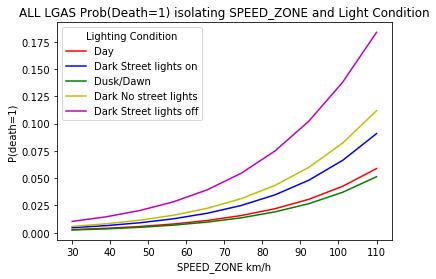

SPEED_ZONE      1.039000
LIGHT_RANK_1    1.598431
LIGHT_RANK_2    0.866012
LIGHT_RANK_3    2.014021
LIGHT_RANK_4    3.597673
intercept       0.000930
dtype: float64


In [49]:
lgas = ["GEELONG", "WYNDHAM", "YARRA RANGES", "BRIMBANK", "MORNINGTON PENINSULA", "SHEPPARTON"]

LGA = ["ALL LGAS"]

for lga in LGA:
    crashes_clean = clean_and_filter_by_LGA(lga)
    main(crashes_clean, lga)
    
# un comment this section if you want to see a logit break down for each lga
# for lga in lgas:
#     crashes_clean = clean_and_filter_by_LGA(lga)
#     main(crashes_clean, lga)

                    LGA  SPEED_ODDS  ALCOHOL_ODDS
0               Wyndham    1.021791     11.181878
1               Geelong    1.033098      9.621303
2              Brimbank    1.006063      7.906362
3          Yarra Ranges    1.039530      6.569752
4            Shepparton    1.048212      6.378146
5  Mornington Peninsula    1.032096      1.486298


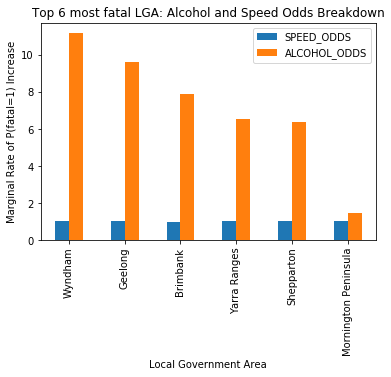

In [50]:
# used to demonstrate disparity in alcohol odds between lgas
odds_alcohol_speed = pd.read_csv('results_speed_alcohol_top_6.csv')
print (odds_alcohol_speed)
odds_alcohol_speed.plot.bar()
plt.xticks([0,1,2,3,4,5], odds_alcohol_speed['LGA'])
plt.title("Top 6 most fatal LGA: Alcohol and Speed Odds Breakdown")
plt.ylabel("Marginal Rate of P(fatal=1) Increase")
plt.xlabel("Local Government Area")
plt.show()

In [ ]:
# for ambulance data:
# ambulance response times cleaned:

ambulance_clean = pd.DataFrame()
ambulance_raw = pd.read_csv('ambulance_response_times.csv')

ambulance_clean['LGA'] = ambulance_raw['lga_name']
ambulance_clean['average_percent_under_15'] = 100*ambulance_raw['average_percent_under_15_minutes_2014-2016']
ambulance_clean['average_response_time_seconds'] = ambulance_raw['average_response_time_seconds_2014-2016']
ambulance_clean['average_response_time_minutes'] = ambulance_raw['average_response_time_seconds_2014-2016'] / 60

for i in range(len(ambulance_clean.index)):
    
    clean = str(ambulance_clean['LGA'][i]).replace("(S)","").replace("(RC)","").replace("(C)","").replace("(B)","").replace("Greater","")
    ambulance_clean.set_value(i,'LGA', clean.upper())

# take out any NaNs by dropping last row, which is a NAN:

ambulance_clean = ambulance_clean[:-1]
    
ambulance_plot = pd.DataFrame()

ambulance_plot['LGA'] = ambulance_clean['LGA']

ambulance_plot['av_time'] = ambulance_clean['average_response_time_minutes']

ambulance_plot_dict = {}

for i in range(len(ambulance_plot.index)):
    
    lga = ambulance_plot['LGA'][i]
    
    ambulance_plot_dict[lga] = ambulance_plot['av_time'][i]
    
# used to find average response times for different LGAs
ambulance_plot_dict  


